In [26]:
import torch
import pyro
import numpy as np
from hysteresis.meshing import exponential_mesh
from hysteresis.base import TorchHysteresis
from hysteresis.bayesian import BayesianHysteresis, positional_covariance, low_hysteresis_prior
from hysteresis.training import train_bayes, map_bayes, mle_bayes
from hysteresis.visualization import plot_hysteresis_density
import matplotlib.pyplot as plt

In [27]:
fname = '../facet_ii_data/quadrupoles/quad_m1-34.ru1'
data = []
with open(fname,'r') as f:
    f.readline()
    for line in f:
        temp = line.rstrip().split(' ')
        d = []
        for ele in temp:
            if ele != '':
                d += [ele]
        data += [d]
data = np.asfarray(data)
data[:, 1] = data[:, 1] / np.max(data[:, 1])
data[:, 3] = data[:, 3] * np.where(data[:,7] < 0, -1, 1)

# get real h, m
h = torch.tensor(data[:,1]).double()
m = torch.tensor(data[:,3]).double()

# normalize m
m = (m - min(m)) / (max(m) - min(m))

def cov(model):
    return positional_covariance(model, 1.0)

def mesh_dens(x, y, scale):
    return exponential_mesh(x, y, scale, min_density=0.005, ls=1.0)

H = TorchHysteresis(h, mesh_scale = 1.0, mesh_density_function=mesh_dens)
B = BayesianHysteresis(H, noise=0.0001)

print(len(H.mesh_points))

calculated 25 states
679


(array([21., 49., 62., 73., 58., 46., 35., 32., 31., 22., 16.,  9., 20.,
         7.,  7.,  3.,  3.,  2.,  2.,  2.]),
 array([0.03815352, 0.1691883 , 0.30022309, 0.43125788, 0.56229266,
        0.69332745, 0.82436223, 0.95539702, 1.08643181, 1.21746659,
        1.34850138, 1.47953617, 1.61057095, 1.74160574, 1.87264052,
        2.00367531, 2.1347101 , 2.26574488, 2.39677967, 2.52781445,
        2.65884924]),
 <BarContainer object of 20 artists>)

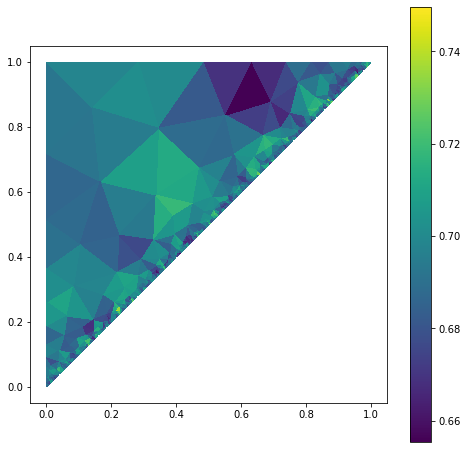

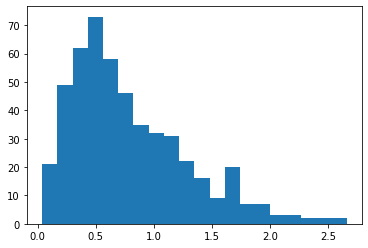

In [28]:
# plot model before training
from hysteresis.bayesian_utils import predict
pred_summary, samples = predict(h, B, None)
den = torch.nn.Softplus()(pred_summary['density']['mean'])

idx = -1
dsamples = torch.nn.Softplus()(samples['density'].squeeze()[:,idx].flatten()).numpy()

fig, ax = plot_hysteresis_density(H, density=den.flatten())
ax.set_aspect('equal')
fig.set_size_inches(8,8)

fig2, ax2 = plt.subplots()
ax2.hist(dsamples, bins=20)

In [33]:
# MAP estimation of parameters
guide, loss = map_bayes(h, m, B, 20000, initial_lr=0.1)

[iteration 0001] loss: 11770250.4785
[iteration 0101] loss: 207182.0232
[iteration 0201] loss: 469927.3349
[iteration 0301] loss: 142686.6054
[iteration 0401] loss: 44205.7870
[iteration 0501] loss: 466016.4455
[iteration 0601] loss: 142788.1686
[iteration 0701] loss: 255704.3017
[iteration 0801] loss: 134107.2360
[iteration 0901] loss: 378523.2399
[iteration 1001] loss: 947898.1805
[iteration 1101] loss: 484438.4912
[iteration 1201] loss: 171710.7465
[iteration 1301] loss: 162537.9496
[iteration 1401] loss: 152233.3837
[iteration 1501] loss: 150878.8395
[iteration 1601] loss: 162814.3302
[iteration 1701] loss: 154905.1487
[iteration 1801] loss: 145774.2256
[iteration 1901] loss: 144533.9994
[iteration 2001] loss: 155457.4833
[iteration 2101] loss: 148202.2302
[iteration 2201] loss: 139872.5018
[iteration 2301] loss: 138733.2564
[iteration 2401] loss: 148674.1617
[iteration 2501] loss: 142054.1661
[iteration 2601] loss: 134437.0879
[iteration 2701] loss: 133401.1624
[iteration 2801] lo

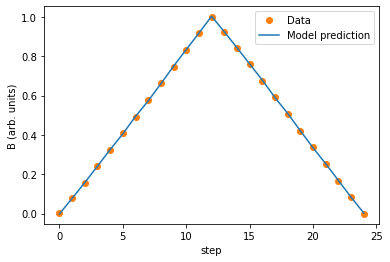

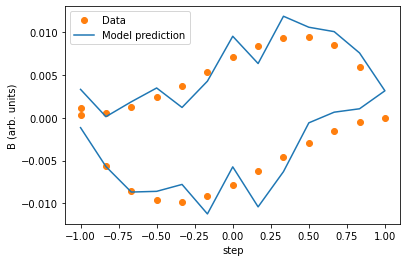

In [30]:
# make predictions
from hysteresis.bayesian_utils import predict
from hysteresis.visualization import plot_bayes_predicition

t = torch.linspace(0, 2*np.pi, 25)
h_test = h#- torch.cos(t)
pred_summary, samples = predict(h_test, B, guide)

plot_bayes_predicition(pred_summary, m)

def fit(x):
    return x/2.0 + 0.5

y = pred_summary['obs']
fig, ax = plt.subplots()
ax.plot(h, m.detach() - fit(h), 'C1o', label='Data')


mean = y['mean'] - fit(h_test)
upper = y['mean'] + y['std'] - fit(h_test)
lower = y['mean'] - y['std'] - fit(h_test)

ax.plot(h_test, mean, 'C0', label='Model prediction')
ax.set_xlabel('step')
ax.set_ylabel('B (arb. units)')
ax.legend()

Parameter containing:
tensor(0.5009, requires_grad=True)
Parameter containing:
tensor(0.4402, requires_grad=True)


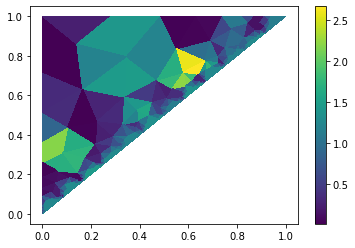

In [31]:
# plot map estimate
den = torch.nn.Softplus()(pyro.param('AutoDelta.density')).detach().numpy()
fig, ax = plot_hysteresis_density(H, den)

print(pyro.param('AutoDelta.offset'))
print(pyro.param('AutoDelta.scale'))


In [32]:
from pyro.infer.autoguide import AutoNormal

# train on data using AutoNormal guide
guide = AutoNormal(B)
guide, loss_trace = train_bayes(h, m, B, 10000, guide=guide)
fig, ax = plt.subplots()
ax.plot(loss_trace)

[iteration 0001] loss: 435957916.2303
[iteration 0101] loss: 498299519.8884
[iteration 0201] loss: 167651874.1686
[iteration 0301] loss: 53297380.4948
[iteration 0401] loss: 57050629.1797
[iteration 0501] loss: 9621089.4241
[iteration 0601] loss: 740087.1805
[iteration 0701] loss: 9717648.0323
[iteration 0801] loss: 5231262.1206
[iteration 0901] loss: 11117516.4827
[iteration 1001] loss: 9648615.9807
[iteration 1101] loss: 24325783.0974
[iteration 1201] loss: 799265.8891
[iteration 1301] loss: 2411153.1142
[iteration 1401] loss: 1208568.2945
[iteration 1501] loss: 2045710.5144
[iteration 1601] loss: 2622298.1685
[iteration 1701] loss: 2237934.1476


KeyboardInterrupt: 

In [ ]:
# make predictions
from hysteresis.bayesian_utils import predict
pred_summary, samples = predict(h, B, guide)

from hysteresis.visualization import plot_bayes_predicition
fig,ax = plot_bayes_predicition(pred_summary, m , False)

In [ ]:
y = pred_summary['obs']
fig, ax = plt.subplots()
ax.plot(m.detach(), 'C1o', label='Data')


mean = y['mean']
upper = y['mean'] + y['std']
lower = y['mean'] - y['std']

ax.plot(mean, 'C0', label='Model prediction')
ax.fill_between(range(len(m)),
                upper,
                lower,
                alpha=0.25)
ax.set_xlabel('step')
ax.set_ylabel('B (arb. units)')
ax.legend()


In [ ]:
import pyro
den = torch.nn.Softplus()(pred_summary['density']['mean'])
print(den.shape)

fig, ax = plot_hysteresis_density(H, density=den.flatten())
ax.set_aspect('equal')
fig.set_size_inches(8,8)

In [ ]:
t = torch.linspace(0, 2*np.pi, 25)
h_test = - torch.cos(t)
#h_test = h


# make predictions
from hysteresis.bayesian_utils import predict
pred_summary, samples = predict(h_test, B, guide)

In [ ]:
def fit(x):
    return x/2.0 + 0.5

y = pred_summary['obs']
fig, ax = plt.subplots()
ax.plot(h, m.detach() - fit(h), 'C1o', label='Data')


mean = y['mean'] - fit(h_test)
upper = y['mean'] + y['std'] - fit(h_test)
lower = y['mean'] - y['std'] - fit(h_test)

ax.plot(h_test, mean, 'C0', label='Model prediction')
ax.fill_between(h_test,
                upper,
                lower,
                alpha=0.25)
ax.set_xlabel('step')
ax.set_ylabel('B (arb. units)')
ax.legend()

In [ ]:
print(samples.keys())
plt.hist(samples['scale'].numpy(), bins=20)
plt.figure()
plt.hist(samples['offset'].numpy(), bins=20)